In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem, rdMolTransforms
import os
import fnmatch
import numpy as np
import deepchem as dc
from scipy.sparse import csr_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.mixture import GMM
import random
from tflearn.activations import leaky_relu
from deepchem.utils.rdkit_util import get_xyz_from_mol
from deepchem.feat.rdkit_grid_featurizer import convert_atom_to_voxel, compute_centroid, rotate_molecules
np.set_printoptions(precision=4)

In [2]:
from deepchem.feat.graph_features import ConvMolFeaturizer
from deepchem.feat.adjacency_fingerprints import AdjacencyFingerprint

In [949]:
def featurize_mols(mol_files, max_n_atoms):
    featurizer = AdjacencyFingerprint(max_n_atoms=max_n_atoms)
    features = []
    for idx, mol_file in enumerate(mol_files):
        if idx % 32 == 0:
            print(idx)
        try:
            bond_dist_mat = np.zeros((max_n_atoms, max_n_atoms))
            angle_mat = np.zeros((max_n_atoms, max_n_atoms, max_n_atoms))
            angle_tuples = np.zeros((max_n_atoms, max_n_atoms, max_n_atoms)).astype(np.uint8)
            
            if ".pdb" in mol_file:
                mol = Chem.MolFromPDBFile(mol_file)
            else:
                mol = Chem.MolFromMol2File(mol_file)
            mol_xyz = get_xyz_from_mol(mol)
            centroid = compute_centroid(mol_xyz)
            mol_xyz -= centroid
            temp = np.zeros((max_n_atoms, 3))
            temp[:mol_xyz.shape[0]] = mol_xyz
            mol_xyz = temp
            
            #mol_xyz = rotate_molecules([mol_xyz])[0]

            c = mol.GetConformer(0)
            
            n_bonds = 0
            n_angles = 0
            for bond in mol.GetBonds():
                n_bonds += 1
                atom_i, atom_j = (bond.GetBeginAtom().GetIdx(), bond.GetEndAtom().GetIdx())
                bond_dist_mat[atom_i, atom_j] = np.power(rdMolTransforms.GetBondLength(c, atom_i, atom_j),2)
                bond_dist_mat[atom_j, atom_i] = np.power(rdMolTransforms.GetBondLength(c, atom_i, atom_j),2)
                
                for sub_bond in bond.GetBeginAtom().GetBonds():
                    atom_k = sub_bond.GetEndAtom().GetIdx()
                    if atom_k == atom_j or atom_k==atom_i: continue
                    angle = np.cos(rdMolTransforms.GetAngleRad(c, atom_j, atom_i, atom_k))
                    angle_mat[atom_i, atom_j, atom_k] = angle
                    angle_mat[atom_i, atom_k, atom_j] = angle
                    
                    angle_tuples[atom_i, atom_j, atom_k] = 1
                    angle_tuples[atom_i, atom_k, atom_j] = 1
                    n_angles += 2
                    
                for sub_bond in bond.GetEndAtom().GetBonds():
                    atom_k = sub_bond.GetEndAtom().GetIdx()
                    if atom_k == atom_i or atom_k==atom_j: continue
                    angle = np.cos(rdMolTransforms.GetAngleRad(c, atom_i, atom_j, atom_k))
                    angle_mat[atom_j, atom_i, atom_k] = angle
                    angle_mat[atom_j, atom_k, atom_i] = angle

                    angle_tuples[atom_j, atom_i, atom_k] = 1
                    angle_tuples[atom_j, atom_k, atom_i] = 1
                    n_angles += 2
                    
            if mol is None:
                features.append(None)
                continue
                
            graph_feat = featurizer.featurize([mol])[0]
            
            features.append((mol_file, bond_dist_mat, mol_xyz, angle_mat, angle_tuples, n_bonds, n_angles, graph_feat))
        except:
            features.append(None)
    return(features)

In [950]:
import pickle
max_n_atoms = 12
S = 64
feature_file = "./voxel_features_pdbbind.pkl"
#if not os.path.exists(feature_file):
if 1== 1:
    pdbbind_dir = "/home/evan/Documents/deep_docking/datasets/v2015/"
    def find_files(directory, pattern):
        for root, dirs, files in os.walk(directory):
            for basename in files:
                if fnmatch.fnmatch(basename, pattern):
                    filename = os.path.join(root, basename)
                    yield filename
    ligand_files = []
    for f in find_files(pdbbind_dir, "*ligand.mol2"):
        ligand_files += [f]
    ligand_files = ligand_files[:] + ["/home/evan/Documents/deep_docking/alanine_dipeptide.pdb"]*S  
    features = featurize_mols(ligand_files, max_n_atoms)
    with open(feature_file, "wb") as f:
        pickle.dump(features, f, protocol=2)
else:
    with open(feature_file, "rb") as f:
        features = pickle.load(f)

0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
896
928
960
992
1024
1056
1088
1120
1152
1184
1216
1248
1280
1312
1344
1376
1408
1440
1472
1504
1536
1568
1600
1632
1664
1696
1728
1760
1792
1824
1856
1888
1920
1952
1984
2016
2048
2080
2112
2144
2176
2208
2240
2272
2304
2336
2368
2400
2432
2464
2496
2528
2560
2592
2624
2656
2688
2720
2752
2784
2816
2848
2880
2912
2944
2976
3008
3040
3072
3104
3136
3168
3200
3232
3264
3296
3328
3360
3392
3424
3456
3488
3520
3552
3584
3616
3648
3680
3712
3744
3776
3808
3840
3872
3904
3936
3968
4000
4032
4064
4096
4128
4160
4192
4224
4256
4288
4320
4352
4384
4416
4448
4480
4512
4544
4576
4608
4640
4672
4704
4736
4768
4800
4832
4864
4896
4928
4960
4992
5024
5056
5088
5120
5152
5184
5216
5248
5280
5312
5344
5376
5408
5440
5472
5504
5536
5568
5600
5632
5664
5696
5728
5760
5792
5824
5856
5888
5920
5952
5984
6016
6048
6080
6112
6144
6176
6208
6240
6272
6304
6336
6368
6400
6432
6464
6496
6528
6560
6592
66

In [959]:
features = [f for f in features if f is not None]

In [960]:
len(features)

994

In [961]:
features[-1][0]

'/home/evan/Documents/deep_docking/alanine_dipeptide.pdb'

In [962]:
features[0][1].shape

(12, 12)

In [1062]:
import tensorflow as tf
tf.reset_default_graph()
alpha = 0.01
n_layers = 1

S = 64

B = max_n_atoms
p = 75

z_dim = 8

L_list = [p, 16, 64, 128, 256]

dihed_per_bond = 1
valence = 4



In [1063]:
with tf.device('/gpu:0'):
    x = tf.placeholder(tf.float32, [S, B, L_list[0]], name="atom_features")
    keep_prob = tf.constant(1.)
    
    adj_matrix = tf.placeholder(tf.float32, shape=[S, B, B], name="adj_matrix")
    
    #dist_matrix2d = tf.placeholder(tf.float32, shape=[S, B, B], name="dist_matrix2d")
    bond_dist_mat = tf.placeholder(tf.float32, shape=[S, B, B], name="bond_dist_mat")
    
    angle_tensor = tf.placeholder(tf.float32, shape=[S, B, B, B], name="angle_tensor")
    angle_tuples = tf.placeholder(tf.float32, shape=[S, B, B, B], name="angle_tuples")
    n_bonds = tf.placeholder(tf.float32, shape=[S,1], name="nbonds")
    n_angles = tf.placeholder(tf.float32, shape=[S,1], name="nangles")
    
    
    mol_xyz = tf.placeholder(tf.float32, shape=[S, B, 3], name="molxyz")
    
    z = tf.random_normal([S, B, z_dim], mean=0, stddev=1)
    
    mol_noise = tf.random_normal([S,B,3], mean=0,stddev=0.0001)


In [1064]:
#adapted from: http://stackoverflow.com/questions/37009647/compute-pairwise-distance-in-a-batch-without-replicating-tensor-in-tensorflow
def compute_distance_matrix(A):
    r = tf.reduce_sum(A*A, 1) # turn r into column vector 
    r = tf.reshape(r, [-1, 1]) 
    D = r - 2*tf.matmul(A, tf.transpose(A)) + tf.transpose(r)
    return(D)

In [1065]:
GW_list = [None for i in range(n_layers)]
Gb_list = [None for i in range(n_layers)]

DW_list = [None for i in range(n_layers)]
Db_list = [None for i in range(n_layers)]


Gh_list = [x]
Dh_list = [x]

adj_list = [adj_matrix]
B_list = [B]
clades_list = []
graph_stride = 1.

print("building clades and adj")
for i in range(n_layers):
    print(i)
    B_list.append(int(np.ceil(B_list[i]/graph_stride)))
    print(B_list)
    clades_list.append(tf.stack([tf.one_hot(range(0,B_list[i],int(graph_stride)), depth=B_list[i])]*S, axis=0)) 


    adj_temp = tf.matmul(clades_list[i], adj_list[i])
    sub_adj = tf.matmul(adj_temp, tf.transpose(adj_temp, perm=[0, 2, 1]))
    sub_adj = tf.minimum(sub_adj, 1.)
    adj_list.append(sub_adj)

print("Building hidden layers")
for layer_idx in range(n_layers):
    GW_list[layer_idx] = tf.Variable(tf.truncated_normal([L_list[layer_idx], L_list[layer_idx+1]], seed=2017), name="GW_list%d" %layer_idx)
    Gb_list[layer_idx] = tf.Variable(tf.ones([1, L_list[layer_idx+1]]))
    
    DW_list[layer_idx] = tf.Variable(tf.truncated_normal([L_list[layer_idx], L_list[layer_idx+1]], seed=2017), name="DW_list%d" %layer_idx)
    Db_list[layer_idx] = tf.Variable(tf.ones([1, L_list[layer_idx+1]]))
    
g_w1_ini = tf.Variable(tf.truncated_normal([1, L_list[n_layers]+z_dim, 64]))
g_w1 = tf.tile(g_w1_ini, [S, 1, 1])

g_b1 = tf.Variable(tf.ones([1, 1, 64]))

g_w2_ini = tf.Variable(tf.truncated_normal([1, 64, 3]))
g_w2 = tf.tile(g_w2_ini, [S, 1, 1])
g_b2 = tf.Variable(tf.ones([1, 1, 3]))

d_w1_ini = tf.Variable(tf.truncated_normal([1, B*(L_list[n_layers]*2+1), 32]))
d_w1 = tf.tile(d_w1_ini, [S, 1, 1])
d_b1 = tf.Variable(tf.ones([1, 1, 32]))

d_w2_ini = tf.Variable(tf.truncated_normal([1, 32, 1]))
d_w2 = tf.tile(d_w2_ini, [S, 1, 1])
d_b2 = tf.Variable(tf.ones([1, 1, 1]))

lam1 = tf.Variable(tf.constant(0.01))
lam2 = tf.Variable(tf.constant(0.01))

building clades and adj
0
[12, 12]
Building hidden layers


In [1066]:
def adjacency_conv_layer(x, W, b, adj, clades, L_in, L_out, layer_idx, S, B):
    with tf.device('/gpu:0'):
        print("layer_idx: %d" %(layer_idx))
        h = tf.matmul(adj, x, name="adj_mult_%d" %layer_idx)
        h = tf.reshape(h, shape=(S*B, L_in), name="adj_reshape_1_%d" %layer_idx)

        h = tf.matmul(h, W, name="adjconv_%d" %layer_idx) + b
    
        h = tf.nn.tanh(h)
        h = tf.reshape(h, (S, B, L_out), name="adj_reshape_2_%d" %layer_idx)  

        h = tf.matmul(clades, h)

        print("within func h:")
        print(h)                                                                                                                              

    return(h)

In [1067]:
#t = sess.run(tf.matmul(dihed_indices[:,:,:,0], x))
#t = np.reshape(t, [t.shape[0]*t.shape[1],t.shape[2]])

In [1068]:
def generator(W_list, b_list, h_list, L_list, n_layers):
    for layer_idx in range(n_layers):
        h_list.append(tf.nn.dropout(adjacency_conv_layer(h_list[layer_idx], W_list[layer_idx],
                                                     b_list[layer_idx], adj_list[layer_idx], 
                                                     clades_list[layer_idx],
                                                     L_list[layer_idx], L_list[layer_idx+1],
                                                     layer_idx, S, B_list[layer_idx]), keep_prob))
    L_final = L_list[n_layers]  
    
    print("h_list[-1]")
    print(h_list[-1])
    
    print("B_list")
    print(B_list)
    
    
    h_final = tf.concat([h_list[-1], z], axis=2)
    
    print("h afterz")
    print(h_final)
    
    g_h1 = tf.nn.tanh(tf.matmul(h_final, g_w1) + g_b1)
    print("g_h1")
    print(g_h1)
    g_h2 = tf.matmul(g_h1, g_w2) + g_b2
    #g_h2 = tf.clip_by_value(g_h2, -10., 10.)
    return(g_h2)



In [1069]:
def discriminator(W_list, b_list, h_list, L_list, n_layers, mols):
    mols = tf.add(mols, mol_noise)
    print("mols")
    print(mols)
    with tf.device('/gpu:0'):
        for layer_idx in range(n_layers):
            h_list.append(tf.nn.dropout(adjacency_conv_layer(h_list[layer_idx], W_list[layer_idx],
                                             b_list[layer_idx], adj_list[layer_idx], 
                                             clades_list[layer_idx],
                                             L_list[layer_idx], L_list[layer_idx+1],
                                             layer_idx, S, B_list[layer_idx]), keep_prob))
        h_final = h_list[-1]

        #COMPUTE ANGLE LOSS:
        i_vec = tf.reshape(mols, [S, B, 1, 3])
        i_vec = tf.tile(i_vec, [1, 1, B, 1])
        
        j_vec = tf.reshape(mols, [S, 1, B, 3])
        j_vec = tf.tile(j_vec, [1, B, 1, 1])
        
        diff = tf.subtract(i_vec, j_vec)
        temp = tf.eye(B, batch_shape=[S])
        temp = tf.reshape(temp, [S, B, B, 1])
        temp = tf.tile(temp, [1, 1, 1, 3])
        diff = diff + temp
        diff = diff / tf.sqrt(tf.reduce_sum(tf.square(diff), axis=3, keep_dims=True))
        temp = tf.sqrt(tf.reduce_sum(tf.square(temp), axis=3, keep_dims=True))
        diff = tf.subtract(diff, temp)
        
        print("diff should be [S, B, B, 3]")
        print(diff)
        
        ij = tf.tile(tf.reshape(diff, [S, B, 1, B, 3]), [1, 1, B, 1, 1])
        ik = tf.tile(tf.reshape(diff, [S, B, B, 1, 3]), [1, 1, 1, B, 1])
        dps = tf.reduce_sum(tf.multiply(ij ,ik), axis=4)
        #dps = tf.where(tf.is_nan(dps), tf.ones_like(dps) * 0., dps)
        print("dps should be [S, B, B, B]")
        print(dps)
        
        #angles_gen = tf.acos(tf.clip_by_value(dps, -1.0, 1.0))
        angles_gen = tf.where(tf.is_nan(dps), tf.zeros_like(dps), dps)
        angles_gen = tf.multiply(angles_gen, angle_tuples)
        
        wrong_angle_loss = tf.reshape(tf.multiply(tf.reduce_sum(tf.squared_difference(angles_gen, angle_tensor), axis=[1,2,3]), lam2), (S,1))
        wrong_angle_loss = tf.where(tf.is_nan(wrong_angle_loss), tf.zeros_like(wrong_angle_loss), wrong_angle_loss)

        #wrong_angle_loss = tf.minimum(wrong_angle_loss, 3.14**2)
        print("wrong_angle_loss")
        print(wrong_angle_loss)
        
        #COMPUTE BOND LOSS:
        
        dist_matrix = tf.concat([tf.reshape(compute_distance_matrix(tf.reshape(mol, [B, 3])), (1, B, B)) for mol in tf.split(mols, S, axis=0)], axis=0)
        #dist_matrix = tf.where(tf.is_nan(dist_matrix), tf.ones_like(dist_matrix) * 0., dist_matrix)
        print("dist_matrix")
        print(dist_matrix)
        #dist_matrix = compute_distance_matrix(mol)
        bond_dist_gen = tf.multiply(dist_matrix, adj_matrix)
        wrong_bond_loss = tf.reshape(tf.multiply(tf.reduce_sum(tf.square(tf.subtract(bond_dist_mat, bond_dist_gen)), axis=[1,2]), lam1), (S,1))
        print("wrong_bond_loss")
        print(wrong_bond_loss)
        
        feat_i = tf.reshape(h_final, (S, B, 1, L_list[n_layers]))
        feat_i = tf.tile(feat_i, [1, 1, B, 1])
        
        feat_j = tf.reshape(h_final, (S, B, 1, L_list[n_layers]))
        feat_j = tf.transpose(feat_j, perm=[0, 2, 1, 3])
        feat_j = tf.tile(feat_j, [1, B, 1, 1])
        
        d_h1 = tf.concat([tf.reshape(dist_matrix, [S, B, B, 1]), feat_i, feat_j], axis=3)
        d_h1 = tf.reshape(d_h1, [S, B, B*(L_list[n_layers]*2+1)])
        d_h2 = leaky_relu(tf.matmul(d_h1, d_w1) + d_b1)
        d_h2 = tf.divide(tf.reduce_sum(tf.matmul(d_h2, d_w2) + d_b2, axis=1), n_bonds)#, axis=1
        print("d_h2")
        print(d_h2)
        
    
    return(tf.add(tf.add(wrong_bond_loss, wrong_angle_loss), d_h2), bond_dist_gen, angles_gen, wrong_bond_loss, wrong_angle_loss)

In [1070]:

theta_D = DW_list[:n_layers] + Db_list[:n_layers] + [d_w1_ini, d_b1, d_w2_ini, d_b2] + [lam1, lam2]

theta_G =  GW_list[:n_layers] + Gb_list[:n_layers] + [g_w1_ini, g_b1, g_w2_ini, g_b2]

In [1071]:
import time 

with tf.device('/gpu:0'):    

    G_sample = generator(GW_list, Gb_list, Gh_list, L_list, n_layers)

    D_real, bond_dist_real, angles_gen_real, wrong_bond_real, wrong_angle_real = discriminator(DW_list, Db_list, Dh_list, L_list, n_layers, mol_xyz)
    D_fake, bond_dist_fake, angles_gen_fake, wrong_bond_fake, wrong_angle_fake = discriminator(DW_list, Db_list, Dh_list, L_list, n_layers, G_sample)


    D_loss = tf.reduce_mean(D_real) - tf.reduce_mean(D_fake)
    G_loss = -tf.reduce_mean(D_fake)
    clip_D = []
    for p in theta_D[:-2]:
        #print(p)
        clip_D.append(p.assign(tf.clip_by_value(p, -0.01, 0.01)))
    clip_D.append(lam1.assign(tf.clip_by_value(lam1, -0.01, 0.01)))
    clip_D.append(lam2.assign(tf.clip_by_value(lam2, -0.01, 0.01)))

    D_solver = (tf.train.RMSPropOptimizer(learning_rate=5e-3)
                .minimize(-D_loss, var_list=theta_D))
    G_solver = (tf.train.RMSPropOptimizer(learning_rate=5e-3)
                .minimize(G_loss, var_list=theta_G))

mb_size = S

sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(tf.global_variables_initializer())


preds = []

d_losses = []
g_losses = []
#print(sess.run(label_placeholder))


    

layer_idx: 0
within func h:
Tensor("MatMul_2:0", shape=(64, 12, 16), dtype=float32, device=/device:GPU:0)
h_list[-1]
Tensor("MatMul_2:0", shape=(64, 12, 16), dtype=float32, device=/device:GPU:0)
B_list
[12, 12]
h afterz
Tensor("concat:0", shape=(64, 12, 24), dtype=float32, device=/device:GPU:0)
g_h1
Tensor("Tanh_1:0", shape=(64, 12, 64), dtype=float32, device=/device:GPU:0)
mols
Tensor("Add:0", shape=(64, 12, 3), dtype=float32, device=/device:GPU:0)
layer_idx: 0
within func h:
Tensor("MatMul_5:0", shape=(64, 12, 16), dtype=float32, device=/device:GPU:0)
diff should be [S, B, B, 3]
Tensor("Sub_1:0", shape=(64, 12, 12, 3), dtype=float32, device=/device:GPU:0)
dps should be [S, B, B, B]
Tensor("Sum_2:0", shape=(64, 12, 12, 12), dtype=float32, device=/device:GPU:0)
wrong_angle_loss
Tensor("Select_1:0", shape=(64, 1), dtype=float32, device=/device:GPU:0)
dist_matrix
Tensor("concat_1:0", shape=(64, 12, 12), dtype=float32, device=/device:GPU:0)
wrong_bond_loss
Tensor("Reshape_198:0", shape=(6

In [1072]:
def construct_feed_dict(X, start=None,
                      stop=None, y=None,
                      keep_prob=1.0, train=True,
                       shuffle_inds=True):
    a = time.time()
    if start is None:
      start = 0
      stop = len(X)
    
    inds = range(start, stop)
    if shuffle_inds:
        random.shuffle(inds)

    atom_adj_batch = [X[idx][7][0] for idx in inds]
    A_batch = np.array([X[idx][7][1] for idx in inds])
    bond_dist_batch = [X[idx][1] for idx in inds]
    mol_xyz_batch = [X[idx][2] for idx in inds]
    angle_tensor_batch = [X[idx][3] for idx in inds]
    angle_tuples_batch = [X[idx][4] for idx in inds]
    n_bonds_batch = np.reshape(np.array([X[idx][5] for idx in inds]), [S,1])
    n_angles_batch = np.reshape(np.array([X[idx][6] for idx in inds]), [S,1])

    feed_dict = {x: A_batch,
                 adj_matrix: atom_adj_batch,
                 bond_dist_mat: bond_dist_batch,
                 mol_xyz: mol_xyz_batch,
                 angle_tensor: angle_tensor_batch,
                 angle_tuples: angle_tuples_batch,
                 n_bonds: n_bonds_batch,
                 n_angles: n_angles_batch
                }
    t = time.time()-a
    #print("Construct feed dict: %f" %(t))
    return(feed_dict)



In [1073]:
def generate_molecule(mol_file, new_coords, new_file):
    print(mol_file)
    print(new_coords[:4])
    if ".pdb" in mol_file:
        mol = Chem.MolFromPDBFile(mol_file)
    else:
        mol = Chem.MolFromMol2File(mol_file)
    c = mol.GetConformer(0)
    for i in range(mol.GetNumAtoms()):
        c.SetAtomPosition(i, new_coords[i].tolist())
    Chem.MolToMolFile(mol, new_file)

In [1074]:
every = 1000
train_dataset = features[:64*12]
n_train = len(train_dataset)

for it in range(1000000):
    a = time.time()
    random.shuffle(train_dataset)
    feed_dict = construct_feed_dict(train_dataset, 0, S, shuffle_inds=False)
        
    if it % every == 0:
        
        print('Iter: {}'.format(it))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        feed_dict = construct_feed_dict(features, 0, S, shuffle_inds=False)

        print("real:")
        print(feed_dict[mol_xyz][0][:4])
        print("fake:")
        print(sess.run(G_sample, feed_dict=feed_dict)[0][:4])
        
        
        print("bond real:")
        print(sess.run(bond_dist_real, feed_dict=feed_dict)[0][:4,:4])
        #print(sess.run(computed_dist_real, feed_dict=feed_dict)[0][:4])

        #print(feed_dict[bond_dist_mat][0][:4])


        print("bond fake:")
        print(sess.run(bond_dist_fake, feed_dict=feed_dict)[0][:4,:4])
    
        print("angles real:")
        print(feed_dict[angle_tensor][0][2,:4,:4])
        print("angles real computed")
        
        print(sess.run(angles_gen_real, feed_dict=feed_dict)[0][2,:4,:4])
        print("angles fake:")
        print(sess.run(angles_gen_fake, feed_dict=feed_dict)[0][2,:4,:4])
        
        print("bond loss real:")
        print(sess.run(wrong_bond_real, feed_dict=feed_dict)[:4])
        print("bond loss fake:")
        print(sess.run(wrong_bond_fake, feed_dict=feed_dict))[:4] 

        print("angle loss real:")
        print(sess.run(wrong_angle_real, feed_dict=feed_dict)[:4])
        print("angle loss fake:")
        print(sess.run(wrong_angle_fake, feed_dict=feed_dict)[:4])

        print("lam1")
        print(sess.run(lam1, feed_dict=feed_dict))
        print("lam2")
        print(sess.run(lam2, feed_dict=feed_dict))
        
        print("\n\n\n")
        
        generate_molecule(features[0][0], sess.run(G_sample, feed_dict=feed_dict)[0], "/home/evan/Documents/deep_docking/dcgan_pg/DCGAN-tensorflow/generated_mols/%s_test%d.mol" %(features[0][0].split(".")[0].split("/")[-1], it))
        
        feed_dict = construct_feed_dict(features, len(features)-S, len(features), shuffle_inds=False)
        generate_molecule(features[-1][0], sess.run(G_sample, feed_dict=feed_dict)[0], "/home/evan/Documents/deep_docking/dcgan_pg/DCGAN-tensorflow/generated_mols/%s_test%d.mol" %(features[-1][0].split(".")[0].split("/")[-1], it))

        
        

        #print("output_i")
        #print(sess.run(G_sample_output_i, feed_dict=feed_dict))
        #print(sess.run(G_sample, feed_dict=feed_dict))

    #random.shuffle(train_dataset)
    batch_sched = list(range(0, n_train+1,S))
    for j in range(0, len(batch_sched)-1):
        start = batch_sched[j]
        stop = batch_sched[j+1]
        feed_dict = construct_feed_dict(train_dataset, start, stop)
        


        for _ in range(5):
            feed_dict = construct_feed_dict(train_dataset, start, stop)

            _, D_loss_curr, _ = sess.run(
                [clip_D, D_loss, D_solver], feed_dict=feed_dict)
        
        feed_dict = construct_feed_dict(train_dataset, start, stop)

        _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict=feed_dict)
        
        d_losses.append(D_loss_curr)
        g_losses.append(G_loss_curr)
    
    if it % every == 0:
        print(time.time()-a)
        print("Training epoch %d" %it)


Iter: 0
D loss: 0.2102
G_loss: 0.6981
real:
[[-0.0725 -0.0715 -1.7212]
 [-0.8925  0.3145 -0.4713]
 [-0.2245 -0.1035  1.0027]
 [ 1.1895 -0.1395  1.1898]]
fake:
[[  9.6967  -3.463    5.6263]
 [  7.807   -8.3887   7.2354]
 [  7.0076  -7.5695  11.9067]
 [  2.3106   1.1929  12.4035]]
bond real:
[[ 0.      2.3839  0.      0.    ]
 [ 2.3839  0.      2.7935  0.    ]
 [ 0.      2.7935  0.      2.0354]
 [ 0.      0.      2.0354  0.    ]]
bond fake:
[[   0.       72.3746    0.        0.    ]
 [  72.3746    0.      154.1889    0.    ]
 [   0.      154.1889    0.      209.8706]
 [   0.        0.      209.8706    0.    ]]
angles real:
[[ 0.     0.     0.     0.   ]
 [ 0.     0.     0.    -0.518]
 [ 0.     0.     0.     0.   ]
 [ 0.    -0.518  0.     0.   ]]
angles real computed
[[ 0.      0.     -0.     -0.    ]
 [ 0.      0.     -0.     -0.5178]
 [-0.     -0.      0.      0.    ]
 [-0.     -0.5178  0.      0.    ]]
angles fake:
[[ 0.     0.    -0.     0.   ]
 [ 0.     0.    -0.     0.991]
 [-0.    

0.817284107208
Training epoch 4000
Iter: 5000
D loss: 0.3378
G_loss: 0.7116
real:
[[-0.0725 -0.0715 -1.7212]
 [-0.8925  0.3145 -0.4713]
 [-0.2245 -0.1035  1.0027]
 [ 1.1895 -0.1395  1.1898]]
fake:
[[-0.6138  0.931   4.0623]
 [-2.167   0.9868  3.0767]
 [-3.0572  0.6017  1.3591]
 [-2.5102  0.3291  0.4937]]
bond real:
[[ 0.      2.3847  0.      0.    ]
 [ 2.3847  0.      2.7936  0.    ]
 [ 0.      2.7936  0.      2.0351]
 [ 0.      0.      2.0351  0.    ]]
bond fake:
[[ 0.      3.2758  0.      0.    ]
 [ 3.2758  0.      3.5005  0.    ]
 [ 0.      3.5005  0.      0.8768]
 [ 0.      0.      0.8768  0.    ]]
angles real:
[[ 0.     0.     0.     0.   ]
 [ 0.     0.     0.    -0.518]
 [ 0.     0.     0.     0.   ]
 [ 0.    -0.518  0.     0.   ]]
angles real computed
[[ 0.      0.     -0.     -0.    ]
 [ 0.      0.     -0.     -0.5178]
 [-0.     -0.      0.      0.    ]
 [-0.     -0.5178  0.      0.    ]]
angles fake:
[[ 0.     0.     0.    -0.   ]
 [ 0.     0.     0.    -0.481]
 [ 0.     0.   

0.847877025604
Training epoch 9000
Iter: 10000
D loss: 0.3493
G_loss: 0.7469
real:
[[-0.0725 -0.0715 -1.7212]
 [-0.8925  0.3145 -0.4713]
 [-0.2245 -0.1035  1.0027]
 [ 1.1895 -0.1395  1.1898]]
fake:
[[-5.3746  4.9867  1.9093]
 [-6.7665  4.6652  1.6695]
 [-7.9528  4.3333  0.9116]
 [-9.2605  4.238  -0.5283]]
bond real:
[[ 0.      2.3839  0.      0.    ]
 [ 2.3839  0.      2.7924  0.    ]
 [ 0.      2.7924  0.      2.0358]
 [ 0.      0.      2.0358  0.    ]]
bond fake:
[[  0.0000e+00   2.1112e+00   0.0000e+00   0.0000e+00]
 [  2.1112e+00   0.0000e+00   3.9589e+00   0.0000e+00]
 [  0.0000e+00   3.9589e+00   0.0000e+00   2.5901e+00]
 [  0.0000e+00   0.0000e+00   2.5901e+00   1.5259e-05]]
angles real:
[[ 0.     0.     0.     0.   ]
 [ 0.     0.     0.    -0.518]
 [ 0.     0.     0.     0.   ]
 [ 0.    -0.518  0.     0.   ]]
angles real computed
[[ 0.      0.     -0.     -0.    ]
 [ 0.      0.     -0.     -0.5181]
 [-0.     -0.      0.      0.    ]
 [-0.     -0.5181  0.      0.    ]]
angles fa

0.813397884369
Training epoch 14000
Iter: 15000
D loss: 0.3974
G_loss: 0.8994
real:
[[-0.0725 -0.0715 -1.7212]
 [-0.8925  0.3145 -0.4713]
 [-0.2245 -0.1035  1.0027]
 [ 1.1895 -0.1395  1.1898]]
fake:
[[-5.0406  1.5831  2.2188]
 [-6.3751  1.3652  1.0745]
 [-7.8405  0.4217  0.5836]
 [-8.6679 -0.0748 -0.494 ]]
bond real:
[[ 0.      2.384   0.      0.    ]
 [ 2.384   0.      2.7937  0.    ]
 [ 0.      2.7937  0.      2.0355]
 [ 0.      0.      2.0355  0.    ]]
bond fake:
[[ 0.      3.1868  0.      0.    ]
 [ 3.1868  0.      3.0888  0.    ]
 [ 0.      3.0888  0.      2.957 ]
 [ 0.      0.      2.957   0.    ]]
angles real:
[[ 0.     0.     0.     0.   ]
 [ 0.     0.     0.    -0.518]
 [ 0.     0.     0.     0.   ]
 [ 0.    -0.518  0.     0.   ]]
angles real computed
[[ 0.      0.     -0.     -0.    ]
 [ 0.      0.     -0.     -0.5177]
 [-0.     -0.      0.      0.    ]
 [-0.     -0.5177  0.      0.    ]]
angles fake:
[[ 0.      0.      0.     -0.    ]
 [ 0.      0.      0.     -0.7164]
 [ 0.

0.826155900955
Training epoch 19000
Iter: 20000
D loss: 0.3394
G_loss: 0.356
real:
[[-0.0725 -0.0715 -1.7212]
 [-0.8925  0.3145 -0.4713]
 [-0.2245 -0.1035  1.0027]
 [ 1.1895 -0.1395  1.1898]]
fake:
[[-0.7947 -0.5651  0.0156]
 [-1.5331 -0.9653 -1.544 ]
 [-2.2878 -1.122  -3.2147]
 [-2.5699 -2.4157 -3.8096]]
bond real:
[[ 0.      2.3842  0.      0.    ]
 [ 2.3842  0.      2.7942  0.    ]
 [ 0.      2.7942  0.      2.036 ]
 [ 0.      0.      2.036   0.    ]]
bond fake:
[[  0.0000e+00   3.0057e+00   0.0000e+00   0.0000e+00]
 [  3.0057e+00   0.0000e+00   3.4723e+00   0.0000e+00]
 [  0.0000e+00   3.4723e+00   0.0000e+00   2.1356e+00]
 [  0.0000e+00   0.0000e+00   2.1356e+00   3.8147e-06]]
angles real:
[[ 0.     0.     0.     0.   ]
 [ 0.     0.     0.    -0.518]
 [ 0.     0.     0.     0.   ]
 [ 0.    -0.518  0.     0.   ]]
angles real computed
[[ 0.      0.     -0.     -0.    ]
 [ 0.      0.     -0.     -0.5182]
 [-0.     -0.      0.      0.    ]
 [-0.     -0.5182  0.      0.    ]]
angles fa

0.824743032455
Training epoch 24000
Iter: 25000
D loss: 0.3539
G_loss: 0.2124
real:
[[-0.0725 -0.0715 -1.7212]
 [-0.8925  0.3145 -0.4713]
 [-0.2245 -0.1035  1.0027]
 [ 1.1895 -0.1395  1.1898]]
fake:
[[ 2.4113 -0.9207 -2.9731]
 [ 1.7235 -1.4564 -4.7486]
 [ 1.1134 -1.9728 -5.9714]
 [ 0.5774 -3.1943 -6.6804]]
bond real:
[[ 0.      2.3834  0.      0.    ]
 [ 2.3834  0.      2.7929  0.    ]
 [ 0.      2.7929  0.      2.0362]
 [ 0.      0.      2.0362  0.    ]]
bond fake:
[[ 0.      3.9181  0.      0.    ]
 [ 3.9181  0.      2.09    0.    ]
 [ 0.      2.09    0.      2.5034]
 [ 0.      0.      2.5034  0.    ]]
angles real:
[[ 0.     0.     0.     0.   ]
 [ 0.     0.     0.    -0.518]
 [ 0.     0.     0.     0.   ]
 [ 0.    -0.518  0.     0.   ]]
angles real computed
[[ 0.      0.     -0.     -0.    ]
 [ 0.      0.     -0.     -0.5181]
 [-0.     -0.      0.      0.    ]
 [-0.     -0.5181  0.      0.    ]]
angles fake:
[[ 0.      0.      0.     -0.    ]
 [ 0.      0.      0.     -0.7657]
 [ 0.

0.830872058868
Training epoch 29000
Iter: 30000
D loss: 0.2836
G_loss: 0.4083
real:
[[-0.0725 -0.0715 -1.7212]
 [-0.8925  0.3145 -0.4713]
 [-0.2245 -0.1035  1.0027]
 [ 1.1895 -0.1395  1.1898]]
fake:
[[ 1.9217 -0.7395 -0.7151]
 [ 1.4411 -1.1982 -2.2459]
 [ 0.7307 -1.5223 -4.2048]
 [ 0.7822 -2.309  -5.4167]]
bond real:
[[ 0.      2.3837  0.      0.    ]
 [ 2.3837  0.      2.794   0.    ]
 [ 0.      2.794   0.      2.036 ]
 [ 0.      0.      2.036   0.    ]]
bond fake:
[[  0.0000e+00   2.8137e+00   0.0000e+00   0.0000e+00]
 [  2.8137e+00   0.0000e+00   4.7075e+00   0.0000e+00]
 [  0.0000e+00   4.7075e+00   0.0000e+00   1.7210e+00]
 [  0.0000e+00   0.0000e+00   1.7210e+00   7.6294e-06]]
angles real:
[[ 0.     0.     0.     0.   ]
 [ 0.     0.     0.    -0.518]
 [ 0.     0.     0.     0.   ]
 [ 0.    -0.518  0.     0.   ]]
angles real computed
[[ 0.     0.    -0.    -0.   ]
 [ 0.     0.    -0.    -0.518]
 [-0.    -0.     0.     0.   ]
 [-0.    -0.518  0.     0.   ]]
angles fake:
[[ 0.      

0.83297419548
Training epoch 34000
Iter: 35000
D loss: 0.3234
G_loss: 0.7008
real:
[[-0.0725 -0.0715 -1.7212]
 [-0.8925  0.3145 -0.4713]
 [-0.2245 -0.1035  1.0027]
 [ 1.1895 -0.1395  1.1898]]
fake:
[[ 1.9885 -0.3954 -1.3465]
 [ 1.4474 -0.8389 -3.0626]
 [ 0.6869 -1.1851 -4.5326]
 [ 0.8479 -1.9007 -6.0147]]
bond real:
[[ 0.      2.3846  0.      0.    ]
 [ 2.3846  0.      2.7938  0.    ]
 [ 0.      2.7938  0.      2.0356]
 [ 0.      0.      2.0356  0.    ]]
bond fake:
[[ 0.      3.5644  0.      0.    ]
 [ 3.5644  0.      2.6839  0.    ]
 [ 0.      2.6839  0.      1.279 ]
 [ 0.      0.      1.279   0.    ]]
angles real:
[[ 0.     0.     0.     0.   ]
 [ 0.     0.     0.    -0.518]
 [ 0.     0.     0.     0.   ]
 [ 0.    -0.518  0.     0.   ]]
angles real computed
[[ 0.     0.    -0.    -0.   ]
 [ 0.     0.    -0.    -0.518]
 [-0.    -0.     0.     0.   ]
 [-0.    -0.518  0.     0.   ]]
angles fake:
[[ 0.      0.      0.     -0.    ]
 [ 0.      0.      0.     -0.8444]
 [ 0.      0.      0. 

0.838250160217
Training epoch 39000
Iter: 40000
D loss: 0.3403
G_loss: 0.8026
real:
[[-0.0725 -0.0715 -1.7212]
 [-0.8925  0.3145 -0.4713]
 [-0.2245 -0.1035  1.0027]
 [ 1.1895 -0.1395  1.1898]]
fake:
[[ 1.9148 -0.7933 -1.6911]
 [ 1.3376 -0.9528 -3.4765]
 [ 0.8959 -1.1657 -4.9452]
 [ 1.3825 -1.401  -6.529 ]]
bond real:
[[ -4.7684e-07   2.3840e+00   0.0000e+00   0.0000e+00]
 [  2.3840e+00   0.0000e+00   2.7940e+00   0.0000e+00]
 [  0.0000e+00   2.7940e+00   0.0000e+00   2.0351e+00]
 [  0.0000e+00   0.0000e+00   2.0351e+00   0.0000e+00]]
bond fake:
[[ 0.      3.4743  0.      0.    ]
 [ 3.4743  0.      2.6782  0.    ]
 [ 0.      2.6782  0.      2.5368]
 [ 0.      0.      2.5368  0.    ]]
angles real:
[[ 0.     0.     0.     0.   ]
 [ 0.     0.     0.    -0.518]
 [ 0.     0.     0.     0.   ]
 [ 0.    -0.518  0.     0.   ]]
angles real computed
[[ 0.      0.     -0.     -0.    ]
 [ 0.      0.     -0.     -0.5179]
 [-0.     -0.      0.      0.    ]
 [-0.     -0.5179  0.      0.    ]]
angles f

0.829951047897
Training epoch 44000
Iter: 45000
D loss: 0.2804
G_loss: 0.2292
real:
[[-0.0725 -0.0715 -1.7212]
 [-0.8925  0.3145 -0.4713]
 [-0.2245 -0.1035  1.0027]
 [ 1.1895 -0.1395  1.1898]]
fake:
[[ 1.2905 -0.5133 -2.4778]
 [ 0.6624 -0.8292 -4.072 ]
 [-0.1498 -0.7082 -5.7112]
 [-0.1219 -1.0765 -7.3424]]
bond real:
[[ 0.      2.3846  0.      0.    ]
 [ 2.3846  0.      2.7933  0.    ]
 [ 0.      2.7933  0.      2.0355]
 [ 0.      0.      2.0355  0.    ]]
bond fake:
[[ 0.      2.7872  0.      0.    ]
 [ 2.7872  0.      3.3379  0.    ]
 [ 0.      3.3379  0.      2.8885]
 [ 0.      0.      2.8885  0.    ]]
angles real:
[[ 0.     0.     0.     0.   ]
 [ 0.     0.     0.    -0.518]
 [ 0.     0.     0.     0.   ]
 [ 0.    -0.518  0.     0.   ]]
angles real computed
[[ 0.      0.     -0.     -0.    ]
 [ 0.      0.     -0.     -0.5178]
 [-0.     -0.      0.      0.    ]
 [-0.     -0.5178  0.      0.    ]]
angles fake:
[[ 0.      0.      0.     -0.    ]
 [ 0.      0.      0.     -0.9476]
 [ 0.

0.834118843079
Training epoch 49000
Iter: 50000
D loss: 0.3597
G_loss: 0.3098
real:
[[-0.0725 -0.0715 -1.7212]
 [-0.8925  0.3145 -0.4713]
 [-0.2245 -0.1035  1.0027]
 [ 1.1895 -0.1395  1.1898]]
fake:
[[ 1.4023  1.3426 -3.0463]
 [ 0.5939  0.8057 -4.2779]
 [-0.1029  0.4041 -5.9402]
 [-0.3348  0.012  -7.2281]]
bond real:
[[ 0.      2.3846  0.      0.    ]
 [ 2.3846  0.      2.7934  0.    ]
 [ 0.      2.7934  0.      2.0359]
 [ 0.      0.      2.0359  0.    ]]
bond fake:
[[ 0.      2.6186  0.      0.    ]
 [ 2.6186  0.      2.9963  0.    ]
 [ 0.      2.9963  0.      2.0005]
 [ 0.      0.      2.0005  0.    ]]
angles real:
[[ 0.     0.     0.     0.   ]
 [ 0.     0.     0.    -0.518]
 [ 0.     0.     0.     0.   ]
 [ 0.    -0.518  0.     0.   ]]
angles real computed
[[ 0.      0.     -0.     -0.    ]
 [ 0.      0.     -0.     -0.5181]
 [-0.     -0.      0.      0.    ]
 [-0.     -0.5181  0.      0.    ]]
angles fake:
[[ 0.      0.      0.     -0.    ]
 [ 0.      0.      0.     -0.9537]
 [ 0.

0.845971107483
Training epoch 54000
Iter: 55000
D loss: 0.2849
G_loss: 0.5393
real:
[[-0.0725 -0.0715 -1.7212]
 [-0.8925  0.3145 -0.4713]
 [-0.2245 -0.1035  1.0027]
 [ 1.1895 -0.1395  1.1898]]
fake:
[[ 0.8434 -0.7115 -3.5725]
 [ 0.5483 -1.5075 -5.141 ]
 [ 0.0146 -2.0415 -6.7478]
 [-0.0742 -3.021  -7.9318]]
bond real:
[[ 0.      2.3838  0.      0.    ]
 [ 2.3838  0.      2.7932  0.    ]
 [ 0.      2.7932  0.      2.0354]
 [ 0.      0.      2.0354  0.    ]]
bond fake:
[[ 0.      3.2309  0.      0.    ]
 [ 3.2309  0.      3.7432  0.    ]
 [ 0.      3.7432  0.      1.8234]
 [ 0.      0.      1.8234  0.    ]]
angles real:
[[ 0.     0.     0.     0.   ]
 [ 0.     0.     0.    -0.518]
 [ 0.     0.     0.     0.   ]
 [ 0.    -0.518  0.     0.   ]]
angles real computed
[[ 0.     0.    -0.    -0.   ]
 [ 0.     0.    -0.    -0.518]
 [-0.    -0.     0.     0.   ]
 [-0.    -0.518  0.     0.   ]]
angles fake:
[[ 0.      0.      0.     -0.    ]
 [ 0.      0.      0.     -0.8611]
 [ 0.      0.      0.

0.828935146332
Training epoch 59000
Iter: 60000
D loss: 0.3553
G_loss: 0.8327
real:
[[-0.0725 -0.0715 -1.7212]
 [-0.8925  0.3145 -0.4713]
 [-0.2245 -0.1035  1.0027]
 [ 1.1895 -0.1395  1.1898]]
fake:
[[ 2.8376  1.2117 -1.6074]
 [ 3.0314 -0.0501 -2.7655]
 [ 3.1751 -0.7146 -4.4725]
 [ 3.4161 -1.8519 -5.4395]]
bond real:
[[ 0.      2.3844  0.      0.    ]
 [ 2.3844  0.      2.793   0.    ]
 [ 0.      2.793   0.      2.0361]
 [ 0.      0.      2.0361  0.    ]]
bond fake:
[[ 0.      2.9054  0.      0.    ]
 [ 2.9054  0.      3.4573  0.    ]
 [ 0.      3.4573  0.      2.3588]
 [ 0.      0.      2.3588  0.    ]]
angles real:
[[ 0.     0.     0.     0.   ]
 [ 0.     0.     0.    -0.518]
 [ 0.     0.     0.     0.   ]
 [ 0.    -0.518  0.     0.   ]]
angles real computed
[[ 0.      0.     -0.     -0.    ]
 [ 0.      0.     -0.     -0.5179]
 [-0.     -0.      0.      0.    ]
 [-0.     -0.5179  0.      0.    ]]
angles fake:
[[ 0.     0.     0.    -0.   ]
 [ 0.     0.     0.    -0.876]
 [ 0.     0. 

0.828670978546
Training epoch 64000
Iter: 65000
D loss: 0.3947
G_loss: 0.9709
real:
[[-0.0725 -0.0715 -1.7212]
 [-0.8925  0.3145 -0.4713]
 [-0.2245 -0.1035  1.0027]
 [ 1.1895 -0.1395  1.1898]]
fake:
[[ 2.6761 -0.5465 -1.6991]
 [ 2.579  -1.4586 -3.0962]
 [ 2.8056 -2.21   -4.4039]
 [ 3.3011 -2.6746 -5.7874]]
bond real:
[[ 0.      2.3842  0.      0.    ]
 [ 2.3842  0.      2.7941  0.    ]
 [ 0.      2.7941  0.      2.0354]
 [ 0.      0.      2.0354  0.    ]]
bond fake:
[[ 0.      2.5948  0.      0.    ]
 [ 2.5948  0.      3.3793  0.    ]
 [ 0.      3.3793  0.      1.7313]
 [ 0.      0.      1.7313  0.    ]]
angles real:
[[ 0.     0.     0.     0.   ]
 [ 0.     0.     0.    -0.518]
 [ 0.     0.     0.     0.   ]
 [ 0.    -0.518  0.     0.   ]]
angles real computed
[[ 0.      0.     -0.     -0.    ]
 [ 0.      0.     -0.     -0.5178]
 [-0.     -0.      0.      0.    ]
 [-0.     -0.5178  0.      0.    ]]
angles fake:
[[ 0.      0.      0.     -0.    ]
 [ 0.      0.      0.     -0.9594]
 [ 0.

0.816331148148
Training epoch 69000
Iter: 70000
D loss: 0.3324
G_loss: 0.3596
real:
[[-0.0725 -0.0715 -1.7212]
 [-0.8925  0.3145 -0.4713]
 [-0.2245 -0.1035  1.0027]
 [ 1.1895 -0.1395  1.1898]]
fake:
[[ 2.8069  1.9585 -1.4338]
 [ 2.9574  0.7974 -2.7932]
 [ 3.4848 -0.2282 -4.3307]
 [ 3.2994 -0.6381 -5.6678]]
bond real:
[[ 0.      2.3842  0.      0.    ]
 [ 2.3842  0.      2.7927  0.    ]
 [ 0.      2.7927  0.      2.0348]
 [ 0.      0.      2.0348  0.    ]]
bond fake:
[[ 0.      3.024   0.      0.    ]
 [ 3.024   0.      3.1506  0.    ]
 [ 0.      3.1506  0.      2.2714]
 [ 0.      0.      2.2714  0.    ]]
angles real:
[[ 0.     0.     0.     0.   ]
 [ 0.     0.     0.    -0.518]
 [ 0.     0.     0.     0.   ]
 [ 0.    -0.518  0.     0.   ]]
angles real computed
[[ 0.      0.     -0.     -0.    ]
 [ 0.      0.     -0.     -0.5179]
 [-0.     -0.      0.      0.    ]
 [-0.     -0.5179  0.      0.    ]]
angles fake:
[[ 0.      0.      0.     -0.    ]
 [ 0.      0.      0.     -0.9925]
 [ 0.

KeyboardInterrupt: 

In [981]:
feed_dict = construct_feed_dict(features, 0, S, shuffle_inds=False)

sess.run(G_sample, feed_dict=feed_dict)[0]

array([[-0.6222,  3.1759, -1.7272],
       [-2.3206,  3.5   , -1.361 ],
       [-3.3241,  4.8481, -1.2788],
       [-3.1506,  5.661 , -0.1399],
       [ 3.7804,  1.2327, -2.3614],
       [ 4.117 ,  1.536 , -2.2268],
       [ 3.8312,  1.4693, -2.2949],
       [ 3.9703,  1.5608, -2.1931],
       [ 3.6365,  1.1914, -2.3312],
       [ 4.0506,  1.8041, -1.9465],
       [ 3.7155,  1.3008, -2.2993],
       [ 4.0951,  1.5755, -2.1624]], dtype=float32)

In [982]:
features[0]

('/home/evan/Documents/deep_docking/datasets/v2015/4wks/4wks_ligand.mol2',
 array([[ 0.    ,  2.3839,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
          0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
        [ 2.3839,  0.    ,  2.7936,  0.    ,  0.    ,  0.    ,  0.    ,
          0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
        [ 0.    ,  2.7936,  0.    ,  2.0357,  0.    ,  0.    ,  0.    ,
          0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  2.0357,  0.    ,  0.    ,  0.    ,  0.    ,
          0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
          0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
          0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
          0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    , 

In [955]:
feed_dict = construct_feed_dict(features, len(features)-S, len(features), shuffle_inds=False)
generate_molecule(features[-1][0], sess.run(G_sample, feed_dict=feed_dict)[0], "/home/evan/Documents/deep_docking/dcgan_pg/DCGAN-tensorflow/generated_mols/%s_test%d.mol" %(features[-1][0].split(".")[0].split("/")[-1], it))


/home/evan/Documents/deep_docking/alanine_dipeptide.pdb
[[ 1.2995 -3.2777 -0.0282]
 [ 2.0037 -2.1657 -0.705 ]
 [ 1.5421 -1.8185 -1.3216]
 [-0.0418 -1.6029  0.2904]]


In [ ]:
np.min(results[0])



In [ ]:
np.where(features[0][1][:,:,:,:-1] == 1)

In [886]:
"""
def discriminator(W_list, b_list, h_list, L_list, n_layers, mols):
    mols = tf.add(mols, mol_noise)
    with tf.device('/gpu:0'):
        for layer_idx in range(n_layers):
            h_list.append(tf.nn.dropout(adjacency_conv_layer(h_list[layer_idx], W_list[layer_idx],
                                             b_list[layer_idx], adj_list[layer_idx], 
                                             clades_list[layer_idx],
                                             L_list[layer_idx], L_list[layer_idx+1],
                                             layer_idx, S, B_list[layer_idx]), keep_prob))
        h_final = h_list[-1]
        dist_matrix = tf.concat([tf.reshape(compute_distance_matrix(tf.reshape(mol, [B, 3])), (1, B, B)) for mol in tf.split(mols, S, axis=0)], axis=0)
        print("dist_matrix")
        print(dist_matrix)
        #dist_matrix = compute_distance_matrix(mol)
        bond_dist_gen = tf.multiply(dist_matrix, adj_matrix)
        wrong_bond_loss = tf.divide(tf.reshape(tf.multiply(tf.reduce_sum(tf.square(tf.subtract(bond_dist_mat, bond_dist_gen)), axis=[1,2]), lam1), (S,1)), n_bonds)
        print("wrong_bond_loss")
        print(wrong_bond_loss)

        angles = []
        for i in range(0, B):
            for j in range(0, B):
                ij = mols[:, i,:] - mols[:,j,:]
                ij = ij / tf.sqrt(tf.reduce_sum(tf.square(ij), 1, keep_dims=True))
                #ij shape should be (S, 3)
               # print("ij")
                #print(ij)
                for k in range(0,B):
                    ik = mols[:,i,:] - mols[:,k,:]
                    ik = ik / tf.sqrt(tf.reduce_sum(tf.square(ik), 1, keep_dims=True))

                    #ik shape should be (S, 3)
                    #if i == 0 and j == 0 and k == 0: 
                    #   print("ik")
                     #   print(ik)
                        
                    dp = tf.reduce_sum(tf.multiply(ij, ik), axis=1, keep_dims=True)
                    #dp shape should be (S,1)
                    #if i ==0 and j ==0 and k==0:
                    #    print("dp")
                    #    print(dp)
                    if i == j or i == k or j == k:
                        angle = tf.Variable(tf.constant(np.zeros([4,1]).astype(np.float32)))
                    else:
                        angle = tf.acos(tf.clip_by_value(tf.reduce_sum(tf.multiply(ij, ik), axis=1, keep_dims=True), -1.0, 1.0))
                    #if i ==0 and j==0 and k==0:
                        #print("angle")
                        #print(angle)
                    angles.append(angle)
        angles_gen = tf.reshape(tf.concat(angles, axis=1), [S, B, B, B])
        angles_gen = tf.multiply(angles_gen, angle_tuples)
        wrong_angles_loss = tf.divide(tf.reshape(tf.multiply(tf.reduce_sum(tf.square(tf.subtract(angle_tensor, angles_gen)), axis=[1,2,3]), lam2), (S,1)), n_angles)
                
        feat_i = tf.reshape(h_final, (S, B, 1, L_list[n_layers]))
        feat_i = tf.tile(feat_i, [1, 1, B, 1])
        
        feat_j = tf.reshape(h_final, (S, B, 1, L_list[n_layers]))
        feat_j = tf.transpose(feat_j, perm=[0, 2, 1, 3])
        feat_j = tf.tile(feat_j, [1, B, 1, 1])
        
        d_h1 = tf.concat([tf.reshape(dist_matrix, [S, B, B, 1]), feat_i, feat_j], axis=3)
        d_h1 = tf.reshape(d_h1, [S, B, B*(L_list[n_layers]*2+1)])
        d_h2 = leaky_relu(tf.matmul(d_h1, d_w1) + d_b1)
        d_h2 = tf.divide(tf.reduce_sum(tf.matmul(d_h2, d_w2) + d_b2, axis=1), n_bonds)#, axis=1
        print("d_h2")
        print(d_h2)
        
    
    return(wrong_bond_loss + wrong_angles_loss + d_h2, bond_dist_gen, angles_gen, wrong_bond_loss, wrong_angles_loss)
"""

'\ndef discriminator(W_list, b_list, h_list, L_list, n_layers, mols):\n    mols = tf.add(mols, mol_noise)\n    with tf.device(\'/gpu:0\'):\n        for layer_idx in range(n_layers):\n            h_list.append(tf.nn.dropout(adjacency_conv_layer(h_list[layer_idx], W_list[layer_idx],\n                                             b_list[layer_idx], adj_list[layer_idx], \n                                             clades_list[layer_idx],\n                                             L_list[layer_idx], L_list[layer_idx+1],\n                                             layer_idx, S, B_list[layer_idx]), keep_prob))\n        h_final = h_list[-1]\n        dist_matrix = tf.concat([tf.reshape(compute_distance_matrix(tf.reshape(mol, [B, 3])), (1, B, B)) for mol in tf.split(mols, S, axis=0)], axis=0)\n        print("dist_matrix")\n        print(dist_matrix)\n        #dist_matrix = compute_distance_matrix(mol)\n        bond_dist_gen = tf.multiply(dist_matrix, adj_matrix)\n        wrong_bond_loss = 

In [277]:
mol = Chem.MolFromMol2File(ligand_files[0])
c = mol.GetConformer(0)

In [282]:
c.SetAtomPosition(0, [0., 0., 0.])

In [40]:
np.where(features[2][1][:,:,:,:-1] == 1)

(array([ 2,  7,  9, 12]),
 array([ 4,  4, 13,  9]),
 array([ 5,  6, 11,  8]),
 array([5, 2, 3, 3]))

In [ ]:
results = sess.run(G_sample, feed_dict=feed_dict)

In [ ]:
sess.run(pred_real, feed_dict=feed_dict)

In [ ]:
np.max(results[0][:,:,:,:], axis=-1)

In [615]:
features[0][3]

array([  0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
         2.00000000e+00,   0.00000000e+00,   1.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         4.09600000e+03])

In [297]:
mol = Chem.MolFromMol2File('/home/evan/Documents/deep_docking/datasets/v2015/4wks/4wks_ligand.mol2')
mol.GetNumAtoms()

4

In [295]:
from rdkit.Chem import AllChem
AllChem.Compute2DCoords(mol)

0

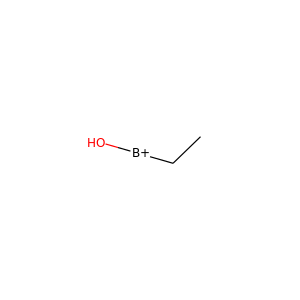

In [296]:
from rdkit.Chem import Draw

Draw.MolToImage(mol)